<center><h1>YOLO11 Training with Privileged Information</h1>
<h2>Matthias Bartolo</h2>

</center>

<h3>Package Imports</h3>

In [1]:
# !pip install --upgrade roboflow ultralytics

In [2]:
# !pip install rasterio

**<h3>Required libraries.</h3>**
https://github.com/ultralytics/ultralytics/issues/2154

Steps to Change the code:
1. Generate the other images (privileged information) and save them in tiff format.
2. Download yolo11 yaml and add to it `ch: 4 # number of channels in the input images`
3. Download ultralytics library and perform the following changes:
4. Code Change 1: tasks.py: create a variable `ch= 4` and from there search for `3,` and where necessary change it to `ch,`
5. Code Change 2: exporter.py: create a variable `ch= 4` and from there search for `3,` and where necessary change it to `ch,`
6. Code Change 3: validator.py: create a variable `ch= 4` and from there search for `3,` and where necessary change it to `ch,`
7. Code Change 4: predictor.py: create a variable `ch= 4` and from there search for `3,` and where necessary change it to `ch,`
8. Code Change 5: checks.py: modify the `amp_allcloseamp_allclose` function and comment the check which utilises the `jpg` image
9. Code Change 6: base.py: Change all the image loading functions to load the tiff images through the `rasterio` library (search for `cv2.imread` and replace it with `rasterio.open`)
10. Code Change 7: base.py: Change the `cv2.imwrite` function to save the tiff images through the `rasterio` library (search for `cv2.imwrite` and replace it with `rasterio.open`)
11. Code Change 8: dataset.py: Change the `cv2.imwrite` function to save the tiff images through the `rasterio` library (search for `cv2.imwrite` and replace it with `rasterio.open`)
12. Code Change 9: plotting.py: Change the plotting functions to plot the rgb images, therefore you need to filter the extra channels from the loaded tiff images

In [3]:
import torch
import os
# import ultralytics
import locale
import glob
import pandas as pd
import matplotlib.pyplot as plt

from IPython import display
from ultralytics import YOLO
from IPython.display import display, Image
from roboflow import Roboflow

%matplotlib inline

**<h3>Using GPU if one is available.</h3>**

In [4]:
!nvidia-smi

Tue Jan 28 09:23:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   36C    P8              8W /  200W |    1532MiB /  12282MiB |      9%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
# Retrieving the current working directory
HOME = os.getcwd()
print(HOME)

e:\Testing


**<h3>Downloading the Roboflow dataset.</h3>**

In [7]:
if not os.path.isdir(os.path.join(HOME, 'datasets')):
    os.mkdir(os.path.join(HOME, 'datasets'))
os.chdir(os.path.join(HOME, 'datasets'))


# Zoo Animals Dataset
rf = Roboflow(api_key="nyynHs3oneLLx01D04rC")
project = rf.workspace("soda-dataset").project("01m-all")
version = project.version(1)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


**<h3>Training the YOLO11 model.</h3>**

In [8]:
# # Added Code for Custom 4 Channel YOLO Model:
# import torch.nn as nn

# # Define the custom YOLO model class (Not working)
# class CustomYOLO(YOLO):
#     def __init__(self, model_path, num_channels):
#         """
#         Initialize the custom YOLO model by adding a custom beginning layer for multi-channel input.
        
#         Args:
#             model_path (str): Path to the pre-trained YOLO model.
#             num_channels (int): Number of input channels (e.g., 3 for RGB, 4 for RGB + edge).
#         """
#         # Load the original YOLO model from the given path
#         super(CustomYOLO, self).__init__(model_path)
        
#         # Access the first convolutional layer of the YOLO model
#         # self.model.model[0] is the first Conv2d layer (backbone structure)
#         # You need to directly assign the custom convolutional layer to this part of the model.
#         # Layer is the same as the normal YOLO model, but input has more channels
#         self.model.model[0] = nn.Sequential(
#             nn.Conv2d(num_channels, 16, kernel_size=3, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(16),
#             nn.SiLU(inplace=True)
#         )

#     def forward(self, x):
#         """
#         Forward pass through the model.
        
#         Args:
#             x (torch.Tensor): Input tensor with multi-channel data.
        
#         Returns:
#             torch.Tensor: The model output after passing through the custom and YOLO layers.
#         """
#         return super(CustomYOLO, self).forward(x)

# # Specify the model path and number of input channels
# model_path = 'yolo11n.pt'  # Path to your YOLO model file
# num_channels = 4  # Example for multi-channel input (e.g., RGB + edge detection)

# # UltraLytics YOLO Model
# # from ultralytics.nn.modules.conv import Conv  # Import the Conv layer from YOLO's common module

# class CustomYOLO(YOLO):
#     def __init__(self, model_path, num_channels):
#         """
#         Initialize the custom YOLO model by adding a custom beginning layer for multi-channel input.
        
#         Args:
#             model_path (str): Path to the pre-trained YOLO model.
#             num_channels (int): Number of input channels (e.g., 3 for RGB, 4 for RGB + edge).
#         """
#         # Load the original YOLO model from the given path
#         super(CustomYOLO, self).__init__(model_path)
        
#         # Modify the first convolution to handle multi-channel input (num_channels)
#         self.model.model[0].conv = nn.Conv2d(num_channels, 16, kernel_size=3, stride=2, padding=1, bias=False)

# # Initialize the custom YOLO model
# model = CustomYOLO(model_path, num_channels)

# print(model)


In [9]:
# class MultiSpectralYOLO(nn.Module):
#     def __init__(self, model_path, num_channels, num_classes):
#         super(MultiSpectralYOLO, self).__init__()
#         self.yolo = YOLO(model_path).model.model
        
#         # Change the first convolutional layer to accept 4-channel input
#         self.yolo[0].conv = nn.Conv2d(num_channels, 16, kernel_size=3, stride=2, padding=1, bias=False)
        
        
#         # Change the last layer to output the correct number of classes
#         # self.yolo[-1].nc = num_classes

#     def forward(self, x):
#         return self.yolo(x)
    
# model = MultiSpectralYOLO(model_path, num_channels, 3)
# print(model)


In [10]:
from ultralytics import YOLO
import torch
model = YOLO("4-channel-yolo11n.yaml")
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

In [11]:
# # Assuming you have a 3-channel input tensor
# sample_input = torch.randn(1, 3, 640, 640)  # RGB (3 channels)
# sample_input = torch.cat([sample_input, torch.zeros(1, 1, 640, 640)], dim=1)  # Add an extra channel
# sample_input/=255

# print(sample_input.shape)
# output = model(sample_input, save=True)
# print(output)

In [12]:
# Specifying the paths
yaml_path  = dataset.location+"/data.yaml"

# Specifying the model path
# model_path = 'yolo11n.pt'

# # Creating YOLO object
# model = YOLO(model_path)

# Specifying training parameters
num_epochs = 100  # Number of epochs
batch_size = 16 #8 # Adjust based on GPU memory
image_size = 640  # Decrease for faster training

# Training configuration
train_config = {
    'data': yaml_path,
    'imgsz': image_size,
    'batch': batch_size,
    'epochs': num_epochs,
    'device': 0,  # Use GPU 0
    # 'workers': 1,  # Number of data loading workers
    'optimizer': 'Adam',  # Use Adam optimizer
    'cache': True,  # Cache images for faster training
    'patience': 15,  # epochs to wait before decreasing LR
    'val': True,  # Run validation during training
    'plots': True,  # Run plots during training
}

# Train the model
model.train(**train_config)


Ultralytics 8.3.68  Python-3.9.19 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
engine\trainer: task=detect, mode=train, model=4-channel-yolo11n.yaml, data=e:\Testing\datasets\01m-All-1/data.yaml, epochs=100, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=0, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labe

train: Scanning E:\Testing\datasets\01m-All-1\train\labels.cache... 316 images, 0 backgrounds, 0 corrupt: 100%|██████████| 316/316 [00:00<?, ?it/s]
Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.


WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
train: Caching images (0.4GB RAM): 100%|██████████| 316/316 [00:04<00:00, 71.51it/s] 
val: Scanning E:\Testing\datasets\01m-All-1\valid\labels.cache... 46 images, 0 backgrounds, 0 corrupt: 100%|██████████| 46/46 [00:00<?, ?it/s]
Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.


WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 46/46 [00:00<00:00, 76.71it/s]


Plotting labels to runs\detect\train6\labels.jpg... 
'Image' object is not subscriptable
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train6
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       2.5G      3.989      5.387      4.187         36        640: 100%|██████████| 20/20 [00:03<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]

                   all         46         84          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.51G      3.046      3.334      3.056         52        640: 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.44it/s]

                   all         46         84          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.52G      2.698      2.871      2.783         34        640: 100%|██████████| 20/20 [00:02<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.47it/s]

                   all         46         84          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.54G      2.589      2.588       2.69         40        640: 100%|██████████| 20/20 [00:02<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

                   all         46         84      0.028     0.0485     0.0439     0.0209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.54G      2.417      2.373      2.524         37        640: 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.03it/s]

                   all         46         84    0.00529     0.0661    0.00299    0.00166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.54G      2.352      2.371      2.462         23        640: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.93it/s]

                   all         46         84   5.44e-05     0.0104   2.97e-05   2.97e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.54G      2.304      2.268       2.44         35        640: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.68it/s]

                   all         46         84     0.0605     0.0854     0.0185    0.00528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.51G      2.233      2.258      2.372         20        640: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.58it/s]

                   all         46         84     0.0632      0.105     0.0308    0.00859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.53G      2.199      2.117      2.339         44        640: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.35it/s]

                   all         46         84      0.434      0.186      0.149     0.0533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.54G      2.157      2.081      2.263         29        640: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.00it/s]

                   all         46         84      0.607     0.0952      0.114     0.0353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.54G      2.053      1.927      2.218         37        640: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.25it/s]

                   all         46         84      0.333      0.222      0.123      0.055



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.51G      2.024      1.941      2.158         35        640: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.64it/s]

                   all         46         84      0.902       0.12      0.138      0.058



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.54G      1.955      1.834      2.102         34        640: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.36it/s]

                   all         46         84      0.608      0.233       0.23      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.54G      1.944      1.857      2.123         39        640: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.31it/s]

                   all         46         84      0.569      0.201      0.239     0.0966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.54G      1.867       1.77      2.105         43        640: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]

                   all         46         84      0.561      0.248      0.243      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.53G      1.833      1.672      2.026         38        640: 100%|██████████| 20/20 [00:02<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.44it/s]

                   all         46         84      0.484      0.154      0.102     0.0441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.51G      1.809      1.634      2.012         38        640: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.32it/s]

                   all         46         84       0.16       0.27      0.173     0.0966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.51G      1.861      1.711      2.074         40        640: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]

                   all         46         84      0.106        0.3      0.164     0.0749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.54G      1.782      1.653      1.967         36        640: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.57it/s]

                   all         46         84      0.587      0.254      0.244      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.54G      1.721      1.552      1.897         30        640: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.68it/s]

                   all         46         84       0.65      0.204      0.236      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.53G      1.724       1.51      1.889         38        640: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]

                   all         46         84      0.535       0.32      0.304      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.51G       1.71      1.586      1.934         46        640: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]

                   all         46         84      0.413      0.392      0.333      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.54G      1.692      1.552      1.906         47        640: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.21it/s]

                   all         46         84      0.182      0.465      0.319      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.54G      1.711      1.497      1.882         28        640: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.63it/s]

                   all         46         84      0.637      0.257      0.318      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.54G      1.699      1.568      1.916         40        640: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.60it/s]

                   all         46         84      0.489      0.352      0.319      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.51G      1.616      1.468      1.797         39        640: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.29it/s]

                   all         46         84      0.293      0.214      0.129     0.0705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.53G      1.647      1.481      1.891         36        640: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.89it/s]

                   all         46         84      0.357      0.374      0.331       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.54G      1.615      1.396      1.851         46        640: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]

                   all         46         84      0.633      0.359      0.372        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.51G      1.543      1.419      1.831         46        640: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]

                   all         46         84      0.388      0.396      0.353      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.51G      1.576      1.386      1.796         46        640: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]

                   all         46         84      0.681      0.337      0.389      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.54G      1.535      1.336      1.746         34        640: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.96it/s]

                   all         46         84      0.574      0.381      0.345      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.54G      1.565      1.351      1.822         34        640: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.97it/s]

                   all         46         84      0.515      0.301      0.385      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.53G      1.519      1.321      1.774         51        640: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.81it/s]

                   all         46         84      0.379       0.48      0.376      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.51G      1.505      1.272      1.737         45        640: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]

                   all         46         84      0.492      0.405      0.336      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.53G      1.496      1.264      1.715         37        640: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]

                   all         46         84      0.633      0.299      0.323      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.53G      1.432      1.222      1.683         26        640: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]

                   all         46         84      0.383      0.464      0.409       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.51G      1.426      1.199      1.704         36        640: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.70it/s]

                   all         46         84      0.562      0.373      0.427      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.54G      1.455      1.275      1.672         35        640: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.48it/s]

                   all         46         84      0.585      0.459      0.432      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.53G      1.422      1.189      1.659         45        640: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]

                   all         46         84      0.546      0.456      0.446      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.51G      1.474      1.213      1.701         29        640: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.72it/s]

                   all         46         84       0.38      0.466      0.405      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.51G      1.438      1.161      1.694         29        640: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]

                   all         46         84      0.553      0.398      0.434      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.51G       1.41      1.163      1.651         27        640: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]

                   all         46         84      0.369      0.426      0.339      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.52G      1.418      1.152      1.707         33        640: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]

                   all         46         84      0.445      0.516      0.457      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.53G      1.354      1.118      1.612         38        640: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]

                   all         46         84      0.407      0.418      0.401       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.51G      1.357      1.171      1.632         39        640: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]

                   all         46         84       0.35      0.478      0.385      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.51G      1.364      1.146      1.657         40        640: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.38it/s]

                   all         46         84      0.405      0.546      0.438      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.54G      1.363      1.087      1.632         27        640: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.72it/s]

                   all         46         84      0.604      0.499      0.475      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.51G       1.37      1.122      1.615         44        640: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.29it/s]

                   all         46         84      0.636       0.37      0.423      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.54G      1.365      1.082      1.629         35        640: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]

                   all         46         84      0.405      0.449      0.412      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.53G      1.312      1.101      1.584         40        640: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.55it/s]

                   all         46         84      0.482      0.392      0.385      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.54G      1.279      1.067      1.578         31        640: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]

                   all         46         84      0.436      0.322      0.278      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.51G      1.328      1.091      1.597         42        640: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.58it/s]

                   all         46         84      0.393      0.379      0.394      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.54G      1.352       1.07      1.617         47        640: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]

                   all         46         84      0.476       0.44      0.439       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.53G      1.341      1.038      1.582         33        640: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]

                   all         46         84      0.368      0.451      0.421       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.54G      1.338      1.065      1.577         40        640: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]

                   all         46         84      0.433      0.466      0.424      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.53G      1.319      1.095      1.618         44        640: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.75it/s]

                   all         46         84       0.51      0.377      0.417      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.53G      1.264     0.9888      1.549         34        640: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.66it/s]

                   all         46         84       0.39      0.486      0.428      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.51G      1.283      1.005      1.564         29        640: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.44it/s]

                   all         46         84      0.636      0.417      0.482      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.54G      1.328      1.041       1.57         38        640: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.31it/s]

                   all         46         84      0.535       0.46      0.475      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.54G      1.279      1.028      1.576         26        640: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]

                   all         46         84      0.536      0.451      0.476       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.51G      1.274     0.9926      1.555         41        640: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]

                   all         46         84      0.426      0.488      0.457      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.51G       1.28     0.9797       1.54         35        640: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]

                   all         46         84      0.512      0.517      0.433      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.51G      1.237     0.9661      1.514         44        640: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]

                   all         46         84      0.579      0.426      0.471      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.52G       1.27      1.009      1.555         24        640: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]

                   all         46         84      0.582      0.468      0.473      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.51G      1.266     0.9549      1.543         38        640: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]

                   all         46         84      0.597      0.452      0.476      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.53G      1.248     0.9545      1.478         34        640: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]

                   all         46         84      0.639      0.465        0.5      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.54G      1.186     0.9309      1.474         59        640: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]

                   all         46         84      0.662      0.483      0.463      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.53G      1.173     0.9095      1.454         32        640: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.76it/s]

                   all         46         84      0.522      0.523      0.479      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.53G      1.159     0.9012      1.485         39        640: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]

                   all         46         84      0.528      0.507      0.505       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.53G      1.179     0.9248      1.494         43        640: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.52it/s]

                   all         46         84      0.542      0.503      0.521      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.53G      1.144     0.9056      1.483         31        640: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.27it/s]

                   all         46         84      0.696      0.502      0.545      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.53G       1.14     0.9155      1.465         44        640: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.21it/s]

                   all         46         84      0.595      0.524      0.506      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.53G      1.137     0.8869      1.474         49        640: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.09it/s]

                   all         46         84      0.658      0.444      0.545      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.54G      1.177      0.901      1.491         40        640: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.16it/s]

                   all         46         84       0.54      0.496       0.48      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.53G       1.12     0.8645      1.448         32        640: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]

                   all         46         84      0.585      0.557      0.567      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.51G      1.108      0.845      1.442         35        640: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]

                   all         46         84      0.688      0.435      0.491      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.53G      1.118     0.8462      1.413         47        640: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]

                   all         46         84      0.636      0.551      0.561      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.54G      1.097     0.8418       1.41         46        640: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]

                   all         46         84      0.491        0.5      0.482      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.54G      1.082     0.8471      1.389         38        640: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.46it/s]

                   all         46         84      0.634      0.513      0.532      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.53G      1.119     0.8559      1.467         31        640: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.19it/s]

                   all         46         84      0.567      0.511      0.546      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.51G      1.059      0.812      1.374         32        640: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.77it/s]

                   all         46         84      0.582      0.556      0.534      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.53G      1.104      0.829      1.385         43        640: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.97it/s]

                   all         46         84       0.58       0.51      0.513       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.51G       1.13     0.8514      1.437         30        640: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.57it/s]

                   all         46         84      0.511      0.508      0.513      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.54G      1.051     0.8118      1.381         42        640: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.52it/s]

                   all         46         84      0.517      0.587      0.535      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.53G      1.072     0.8076      1.427         37        640: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.64it/s]

                   all         46         84      0.698      0.492      0.562      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.51G      1.062     0.8007      1.404         39        640: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]

                   all         46         84        0.6      0.554      0.546      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.53G      1.025     0.8005       1.35         38        640: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.00it/s]

                   all         46         84      0.506      0.515      0.504      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.53G      1.046     0.8164      1.389         43        640: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.77it/s]

                   all         46         84      0.619      0.553      0.552      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.51G      1.042     0.7983      1.369         31        640: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.55it/s]

                   all         46         84      0.775      0.478      0.574      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.54G       1.03     0.7719      1.359         36        640: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]

                   all         46         84      0.705      0.512      0.557      0.365


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.52G      1.336      1.278      1.839         15        640: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]

                   all         46         84      0.719      0.402      0.498      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.52G      1.244      1.093      1.705         16        640: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.69it/s]

                   all         46         84      0.523      0.475      0.513      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       2.5G      1.207      1.073      1.683         18        640: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]

                   all         46         84      0.542      0.509       0.55      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.52G      1.136      1.003      1.671         21        640: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.84it/s]

                   all         46         84      0.757      0.475      0.589       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.52G       1.12     0.9902      1.619         14        640: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.69it/s]

                   all         46         84      0.727      0.434      0.544      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.52G      1.121     0.9495       1.62         15        640: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]

                   all         46         84       0.52      0.518      0.538      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.52G      1.114     0.9609      1.604         20        640: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.42it/s]

                   all         46         84      0.624      0.563      0.563      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.52G      1.112     0.9552      1.592         22        640: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.52it/s]

                   all         46         84      0.542      0.548      0.528      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       2.5G      1.085     0.9282      1.587         20        640: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.63it/s]

                   all         46         84      0.522      0.554      0.528      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.52G      1.052     0.9175      1.564         16        640: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]

                   all         46         84      0.604      0.551      0.546      0.348



100 epochs completed in 0.083 hours.
Optimizer stripped from runs\detect\train6\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train6\weights\best.pt, 5.5MB

Validating runs\detect\train6\weights\best.pt...
Ultralytics 8.3.68  Python-3.9.19 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
4-channel-YOLO11n summary (fused): 238 layers, 2,583,466 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.20it/s]


                   all         46         84      0.777      0.478      0.574      0.387
  clear_plastic_bottle         12         16      0.917      0.375      0.661      0.428
             drink_can         25         35      0.951      0.886      0.937       0.69
          drink_carton          5          6      0.648       0.62       0.59      0.431
          glass_bottle         11         13      0.548      0.231      0.381      0.208
             glass_jar          5          5      0.596        0.6       0.55      0.371
  other_plastic_bottle          5          9          1      0.155      0.327      0.194
Speed: 0.2ms preprocess, 3.1ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\detect\train6


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001CB6CA3CA90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
 

**<h3>Validating the YOLO11 model on the Validation subset.</h3>**

In [13]:
locale.getpreferredencoding = lambda: "UTF-8"
# !pip install aspose-words

In [14]:
model.val() #This will output a train file however it will be on the validation data

Ultralytics 8.3.68  Python-3.9.19 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
4-channel-YOLO11n summary (fused): 238 layers, 2,583,466 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning E:\Testing\datasets\01m-All-1\valid\labels.cache... 46 images, 0 backgrounds, 0 corrupt: 100%|██████████| 46/46 [00:00<?, ?it/s]
Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.


WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 46/46 [00:00<00:00, 82.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]


                   all         46         84      0.779      0.477      0.573       0.39
  clear_plastic_bottle         12         16       0.92      0.375      0.661      0.427
             drink_can         25         35      0.955      0.886      0.936      0.694
          drink_carton          5          6      0.647      0.617      0.588      0.429
          glass_bottle         11         13      0.554      0.231      0.373      0.222
             glass_jar          5          5      0.598        0.6       0.55      0.371
  other_plastic_bottle          5          9          1      0.153       0.33      0.196
Speed: 2.7ms preprocess, 10.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\detect\train62


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001CB9EE9F880>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
 

**<h3>Validating the YOLO11 model on the Testing subset.</h3>**

In [15]:
model.val(split='test') #This will output a train file however it will be on the test data

Ultralytics 8.3.68  Python-3.9.19 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)


val: Scanning E:\Testing\datasets\01m-All-1\test\labels.cache... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<?, ?it/s]
Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.


WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 90/90 [00:01<00:00, 80.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


                   all         90        141      0.673      0.708      0.716       0.49
  clear_plastic_bottle         29         33      0.801      0.697       0.85      0.549
             drink_can         38         53       0.83      0.925      0.957      0.673
          drink_carton          8          8      0.369          1      0.475       0.38
          glass_bottle         16         18      0.412      0.556      0.516      0.226
             glass_jar         11         11      0.628      0.545      0.673      0.473
  other_plastic_bottle         15         18          1      0.525      0.824      0.637
Speed: 1.5ms preprocess, 6.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\train63


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001CB9F5CCCD0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
 

**<h3>Testing the YOLO11 model on the Testing subset.</h3>**

In [16]:
!yolo task=detect \
mode=predict \
model=E:/Testing/datasets/runs/detect/train5/weights/best.pt \
conf=0.2 \
source=E:/Testing/datasets/01m-All-1/test/images \
save=True

Ultralytics 8.3.67 🚀 Python-3.9.19 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
4-channel-YOLO11n summary (fused): 238 layers, 2,583,466 parameters, 0 gradients, 6.3 GFLOPs



Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\yolov10\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\User\anaconda3\envs\yolov10\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\User\anaconda3\envs\yolov10\Scripts\yolo.exe\__main__.py", line 7, in <module>
  File "C:\Users\User\anaconda3\envs\yolov10\lib\site-packages\ultralytics\cfg\__init__.py", line 986, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
  File "C:\Users\User\anaconda3\envs\yolov10\lib\site-packages\ultralytics\engine\model.py", line 558, in predict
    return self.predictor.predict_cli(source=source) if is_cli else self.predictor(source=source, stream=stream)
  File "C:\Users\User\anaconda3\envs\yolov10\lib\site-packages\ultralytics\engine\predictor.py", line 190, in predict_cli
    for _ in gen:  # sourcery skip: remove-empty-nested-block, noqa
  File "C:\Users\Use

In [17]:
model_path = 'E:/Testing/datasets/runs/detect/train5/weights/best.pt'
model = YOLO(model_path)
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

**<h3>Training Results.</h3>**

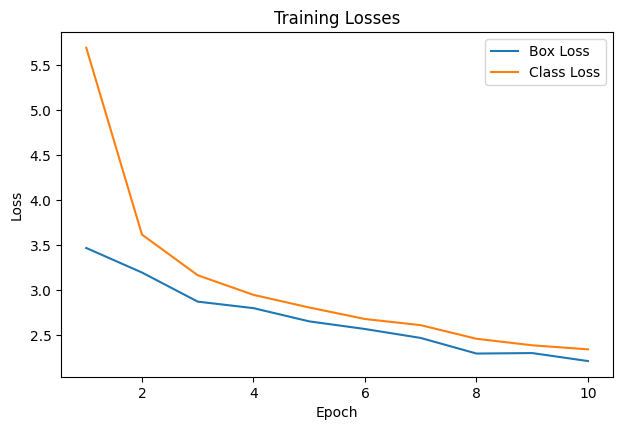

In [18]:
# # Replace 'path/to/your/data.csv' with the actual path to your CSV file
file_path = 'E:/Testing/datasets/runs/detect/train4/results.csv'

column_name = 'epoch'

# Read the CSV file into a pandas DataFrame
data = pd.read_csv(file_path)

# Remove leading spaces from column names
data.columns = data.columns.str.strip()

# Plotting
plt.figure(figsize=(12, 8))

# Plotting the training losses
plt.subplot(2, 2, 1)
plt.plot(data['epoch'], data['train/box_loss'], label='Box Loss')
plt.plot(data['epoch'], data['train/cls_loss'], label='Class Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


**<h3>Validation Results.</h3>**

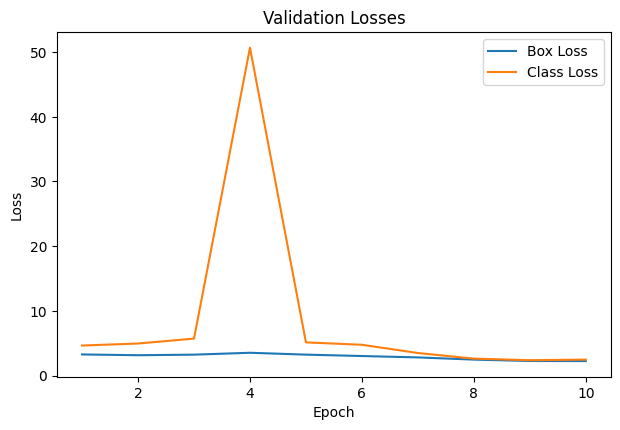

In [19]:
# Plotting
plt.figure(figsize=(12, 8))

# Plotting the training losses
plt.subplot(2, 2, 1)
plt.plot(data['epoch'], data['val/box_loss'], label='Box Loss')
plt.plot(data['epoch'], data['val/cls_loss'], label='Class Loss')
plt.title('Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

**<h3>Testing Resultant Images.</h3>**

In [20]:
counter =0
limit = 10
for image_path in glob.glob(f'{HOME}/datasets/runs/detect/predict/*.jpg'):
      display(Image(filename=image_path))
      print("\n")
      counter += 1
      if counter == limit:
          break